In [1]:
'''
This document is for testing energy extraction methods
'''
%load_ext autoreload
%autoreload 2

In [2]:
import dataFile as df #class to open the data file
import matplotlib.pyplot as plt #plotting utility
import numpy as np 
from scipy import signal #used for convolutions
from scipy import optimize #used for fitting
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d
import os #used for file operations
import pickle #used for saving temporary results
import time

from multiprocessing import Lock, Process, Queue, current_process #to make things faster
import multiprocessing as mp

#advanced plotting routines
from pylab import rcParams
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from pylab import rcParams

In [15]:
#the file to open and play with
channel = 9
filename = '/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/beamOnFolder/2 inch collimation/beam on/2inchCollimationBeamOn_25-30ms/run73437.bin'
datafile = df.dataFile(filename)
waves = datafile.getPixel(channel)

In [38]:
def trapFilt(rise, top, tau):
    #first define the filter
    filt = np.zeros(rise * 2 + top)
    for i in range(rise):
        filt[i] = i+tau
        filt[i+rise+top] = rise-tau-i
    for i in range(rise, rise+top):
        filt[i]=rise
    scale = 1.0/(rise * tau)
    filt = np.multiply(filt, scale) 
    return filt

def trapezoidalFilter(wave, rise, top, tau):
    filt = trapFilt(rise, top, tau)
    #now apply the filter
    res = signal.fftconvolve(wave, filt, mode='same')
    return res


def method1(wave, decayrate, length):
    wave = wave.astype(np.float64)
    wave = wave[:]*-1
    wave = wave - np.mean(wave[:1000])
    halfPoint = int(np.floor(length/2))
    x = np.arange(length)
    fitFunc = np.zeros(length)
    fitFunc[halfPoint:] = np.exp(-1*x[:halfPoint] / decayrate)
    const = np.ones(length)
    linear = x[:]/np.max(x)
    fitFuncs = np.asarray([fitFunc, const, linear])
    fitFuncs = np.transpose(fitFuncs)
    pinv = np.linalg.pinv(fitFuncs)
    plt.plot(fitFuncs)
    plt.show()
    fitResults = signal.convolve(wave, np.flip(pinv[0]), mode='same')
    enerRise = 90
    enerTop = 20
    enerTau = 90
    trapResults = trapezoidalFilter(wave, enerRise, enerTop, enerTau)
    peaks, props = signal.find_peaks(fitResults, height = 20, 
                                     threshold = None,
                                     distance = length*2,
                                     width = None,
                                     wlen = None,
                                     rel_height = None,
                                     plateau_size = None)
    realPeakLocs = []
    realPeakHeights = []
    for peak in peaks:
        realPeakLocs.append(peak)
        realPeakHeights.append(fitResults[peak])
    plt.plot(wave)
    plt.plot(fitResults)
    plt.plot(trapResults)
    plt.scatter(realPeakLocs, realPeakHeights, color='red', s = 100)
    plt.xlim(152000, 155000)
    plt.show()
    return fitResults
    
    

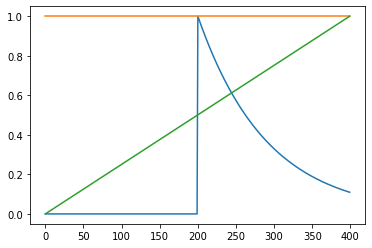

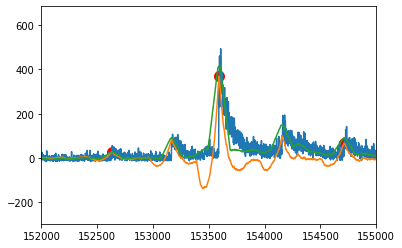

In [39]:
fitresults = method1(waves[0], 90, 400)